In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import FormatStrFormatter

from qrisp.operators import X, Y, Z
from qrisp.vqe.problems.heisenberg import *
import networkx as nx

import pickle
from time import time
from datetime import datetime

def save_data(data, filename):  
    # Open a file for writing
    with open(filename+'.pickle', 'wb') as file:
        # Write the object to the file
        pickle.dump(data, file)

def load_data(filename):
    with open(filename+'.pickle', 'rb') as file:
        # Load the object from the file
        data = pickle.load(file)
    return data

In [3]:
L = 10
G = nx.Graph()
G.add_edges_from([(k,(k+1)%L) for k in range(L-1)]) 

J = 1

B1 = 0.5
H1 = create_heisenberg_hamiltonian(G, J, B1)

B2 = 1
H2 = create_heisenberg_hamiltonian(G, J, B2)

H1_matrix = H1.to_array()
eigvalsA, eigvecsA = np.linalg.eigh(H1_matrix)
idx = np.argsort(eigvalsA)
eigvalsA_sorted = eigvalsA[idx].real
#print('Eigen energies:', eigvals1_sorted)
eigvecsA_sorted = eigvecsA[:,idx].T
eigvecsA_sorted = [vec.reshape(-1,1) for vec in eigvecsA_sorted]

H2_matrix = H2.to_array()
eigvalsB, eigvecsB = np.linalg.eigh(H2_matrix)
idx = np.argsort(eigvalsB)
eigvalsB_sorted = eigvalsB[idx].real
#print('Eigen energies:', eigvals1_sorted)
eigvecsB_sorted = eigvecsB[:,idx].T
eigvecsB_sorted = [vec.reshape(-1,1) for vec in eigvecsB_sorted]


In [4]:
# OLD DATA
#resultsA = load_data('data/benchmarks_2nd_B=0.5_03-20-18') # B=0.5
#resultsB = load_data('data/benchmarks_2nd_B=1_03-20-20') # B=1

#NEW DATA
resultsA = load_data('data/benchmarks_2nd_B=0.5_03-25-14') # B=0.5
resultsB = load_data('data/benchmarks_2nd_B=1_03-25-18') # B=1

In [5]:
def run_param_rc(fontsize = 30):
        import matplotlib.pyplot as plt
        plt.rcParams['axes.labelsize'] = fontsize
        plt.rcParams['axes.titlesize'] = fontsize
        plt.rcParams['font.size'] = fontsize
        #set_matplotlib_formats('pdf', 'png')
        plt.rcParams['savefig.dpi'] = 75
        plt.rcParams['lines.linewidth'] = 2.0
        plt.rcParams['lines.markersize'] = 8
        plt.rcParams['legend.fontsize'] = 12
        plt.rcParams['legend.labelspacing'] = .3
        plt.rcParams['legend.columnspacing']= .3
        plt.rcParams['legend.handletextpad']= .1
        plt.rcParams['text.usetex'] = True
        plt.rcParams['font.family'] = "serif"
        plt.rcParams['font.serif'] = "cm"

run_param_rc(18)

# QITE with Singlet and VQE warm start

/var/folders/sn/4ym_qb8x0cs_f961d78kvvkc0000gn/T/ipykernel_70641/2275002554.py:257: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


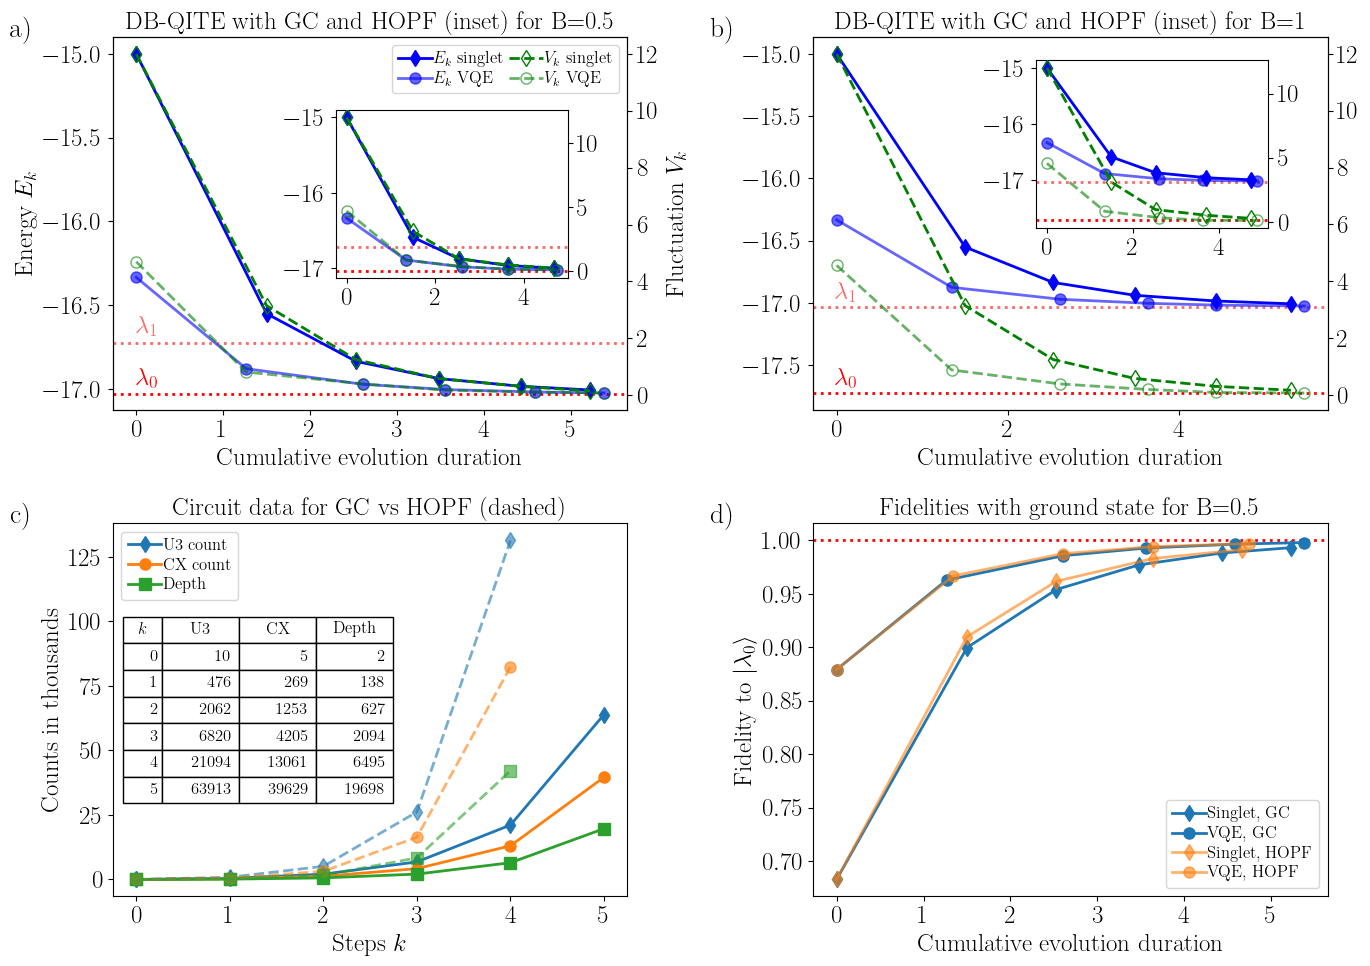

In [50]:
alphas = [1.0, 0.6]
markers = ['d','o']

lables_energies=["$E_k$ singlet","$E_k$ singlet","$E_k$ VQE","$E_k$ VQE"]
lables_fluctuations=["$V_k$ singlet","$V_k$ singlet","$V_k$ VQE","$V_k$ VQE"]

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, ((ax_energy1, ax_energy2), (ax_circuits, ax_fidelities)) = plt.subplots(2, 2, 
                                             figsize=(14, 10), 
                                             gridspec_kw={"width_ratios": [1, 1], "height_ratios": [1,1]})

a = -0.2
b = 1.0
ax_energy1.annotate('a)', xy = (a,b), xycoords='axes fraction', fontsize=20)
ax_energy2.annotate('b)', xy = (a,b), xycoords='axes fraction', fontsize=20)
ax_circuits.annotate('c)', xy = (a,b), xycoords='axes fraction', fontsize=20)
ax_fidelities.annotate('d)', xy = (a,b), xycoords='axes fraction', fontsize=20)

###############################################################################
# SUBPLOT 1: Energy + fluctuation (with a twin y-axis) for B=0.5 (results1), GC
###############################################################################
axA1 = ax_energy1  # rename for clarity

indices = [0,2] # GC
#indices = [1,3] # HOPF

beta_max = np.max([np.max(resultsA[i]['evolution_times']) for i in indices])

# 1) Plot energies on the left y-axis
for i,ind in enumerate(indices):
    line1, = axA1.plot(resultsA[ind]['evolution_times'], resultsA[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

axA1.axhline(y=eigvalsA_sorted[0], color="red", linestyle=':')
axA1.axhline(y=eigvalsA_sorted[1], color="red", linestyle=':', alpha = 0.6)

axA1.text(
    0,           # shift text slightly to the right
    eigvalsA_sorted[0]+0.1,             # same y as the line
    r"$\lambda_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)
axA1.text(
    0,           # shift text slightly to the right
    eigvalsA_sorted[1]+0.1,             # same y as the line
    r"$\lambda_1$",                           # label for that line
    va="center",
    ha="left",
    color="red",
    alpha = 0.6
)

axA1.set_xlabel("Cumulative evolution duration")
axA1.set_ylabel(r"Energy $E_k$")

# 2) Create a twin axis for fluctuations
axA2 = axA1.twinx()

for i,ind in enumerate(indices):
    line2, = axA2.plot(resultsA[ind]['evolution_times'], resultsA[ind]['variances'], label=lables_fluctuations[ind], color='green',  linestyle='dashed', marker=markers[i], markerfacecolor='none', linewidth=2, zorder=3, alpha=alphas[i])
axA2.set_ylabel(r"Fluctuation $V_k$")

# 3) Combine legends from both axes
lines_1, labels_1 = axA1.get_legend_handles_labels()
lines_2, labels_2 = axA2.get_legend_handles_labels()
axA1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best", ncol=2)

axA1.set_title('DB-QITE with GC and HOPF (inset) for B=0.5')

###############################################################################
# Inset plot: Energy + fluctuation (with a twin y-axis) for B=0.5 HOPF
###############################################################################

# Define inset axes
axA3 = inset_axes(axA1, width="45%", height="45%", loc="center right", bbox_to_anchor=(0-0.1, 0.08, 1, 1),
                  bbox_transform=axA1.transAxes,)

indices = [1,3] # HOPF

# 1) Plot energies on the left y-axis
for i,ind in enumerate(indices):
    line1, = axA3.plot(resultsA[ind]['evolution_times'], resultsA[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

axA3.axhline(y=eigvalsA_sorted[0], color="red", linestyle=':')
axA3.axhline(y=eigvalsA_sorted[1], color="red", linestyle=':', alpha = 0.6)

# 2) Create a twin axis for fluctuations
axA4 = axA3.twinx()
for i,ind in enumerate(indices):
    line2, = axA4.plot(resultsA[ind]['evolution_times'], resultsA[ind]['variances'], label=lables_fluctuations[ind], color='green', marker=markers[i], markerfacecolor='none', linestyle='dashed', linewidth=2, zorder=3, alpha=alphas[i])


###############################################################################
# SUBPLOT 2: Energy + fluctuation (with a twin y-axis) for B=1 (results2), GC
###############################################################################
axB1 = ax_energy2  # rename for clarity

indices = [0,2] # GC
#indices = [1,3] # HOPF

beta_max = np.max([np.max(resultsB[i]['evolution_times']) for i in indices])

# 1) Plot energies on the left y-axis
for i,ind in enumerate(indices):
    line1, = axB1.plot(resultsB[ind]['evolution_times'], resultsB[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

axB1.axhline(y=eigvalsB_sorted[0], color="red", linestyle=':')
axB1.axhline(y=eigvalsB_sorted[1], color="red", linestyle=':', alpha = 0.6)

axB1.text(
    -0.02,           # shift text slightly to the right
    eigvalsB_sorted[0]+0.12,             # same y as the line
    r"$\lambda_0$",                           # label for that line
    va="center",
    ha="left",
    color="red",
)
axB1.text(
    -0.02,           # shift text slightly to the right
    eigvalsB_sorted[1]+0.12,             # same y as the line
    r"$\lambda_1$",                           # label for that line
    va="center",
    ha="left",
    color="red",
    alpha = 0.6
)

axB1.set_xlabel("Cumulative evolution duration")
# axB1.set_ylabel(r"Energy $E_k$")

# 2) Create a twin axis for fluctuations
axB2 = axB1.twinx()
for i,ind in enumerate(indices):
    line2, = axB2.plot(resultsB[ind]['evolution_times'], resultsB[ind]['variances'], label=lables_fluctuations[ind], color='green', markerfacecolor='none', marker=markers[i], linestyle='dashed', linewidth=2, zorder=3, alpha=alphas[i])
# axB2.set_ylabel(r"Fluctuation $V_k$")

# 3) Combine legends from both axes
lines_1, labels_1 = axB1.get_legend_handles_labels()
lines_2, labels_2 = axB2.get_legend_handles_labels()
# axB1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

axB1.set_title('DB-QITE with GC and HOPF (inset) for B=1')

###############################################################################
# Inset plot: Energy + fluctuation (with a twin y-axis) for B=1 HOPF
###############################################################################

# Define inset axes
axB3 = inset_axes(axB1, width="45%", height="45%", loc="upper right", bbox_to_anchor=(0-0.1, 0-0.04, 1, 1),
                  bbox_transform=axB1.transAxes,)

indices = [1,3] # HOPF

# 1) Plot energies on the left y-axis
for i,ind in enumerate(indices):
    line1, = axB3.plot(resultsB[ind]['evolution_times'], resultsB[ind]['optimal_energies'], label=lables_energies[ind], color='blue', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=alphas[i])

axB3.axhline(y=eigvalsB_sorted[0], color="red", linestyle=':')
axB3.axhline(y=eigvalsB_sorted[1], color="red", linestyle=':', alpha = 0.6)

# 2) Create a twin axis for fluctuations
axB4 = axB3.twinx()
for i,ind in enumerate(indices):
    line2, = axB4.plot(resultsB[ind]['evolution_times'], resultsB[ind]['variances'], label=lables_fluctuations[ind], color='green', marker=markers[i], markerfacecolor='none', linestyle='dashed', linewidth=2, zorder=3, alpha=alphas[i])

  
###############################################################################
# SUBPLOT 3: Circuit data for GC, Singlet
###############################################################################

axC = ax_circuits  # rename for clarity

steps_gc = [0,1,2,3,4,5]
u_count_gc = np.array([resultsA[0]["circuit_data"][0][k]['u3'] for k in steps_gc])
cx_count_gc = np.array([resultsA[0]["circuit_data"][0][k]['cx'] for k in steps_gc])
depth_gc = np.array([resultsA[0]["circuit_data"][2][k] for k in steps_gc])

steps_hopf = [0,1,2,3,4]
u_count_hopf = np.array([resultsA[1]["circuit_data"][0][k]['u3'] for k in steps_hopf])
cx_count_hopf = np.array([resultsA[1]["circuit_data"][0][k]['cx'] for k in steps_hopf])
depth_hopf = np.array([resultsA[1]["circuit_data"][2][k] for k in steps_hopf])

scaling = 1000

axC.plot(steps_gc, u_count_gc/scaling, color='#1f77b4', marker='d', label='U3 count')
axC.plot(steps_gc, cx_count_gc/scaling, color='#ff7f0e', marker='o', label='CX count')
axC.plot(steps_gc, depth_gc/scaling, color='#2ca02c', marker='s', label='Depth')

axC.plot(steps_hopf, u_count_hopf/scaling, marker='d', color='#1f77b4', alpha=0.6, linestyle='dashed')
axC.plot(steps_hopf, cx_count_hopf/scaling, marker='o', color='#ff7f0e', alpha=0.6, linestyle='dashed')
axC.plot(steps_hopf, depth_hopf/scaling, marker='s', color='#2ca02c', alpha=0.6, linestyle='dashed')

axC.set_xlabel(r"Steps $k$")
axC.set_ylabel("Counts in thousands")

axC.legend(loc="best")
axC.set_title('Circuit data for GC vs HOPF (dashed)')

###############################################################################
# Inset table: circuit data GC
###############################################################################

# Data for the table
rows = [' 0 ', '1', '2', '3', '4','5']
columns = (r'$k$','U3', 'CX', 'Depth')
cell_text = [[rows[i], u_count_gc[i], cx_count_gc[i], depth_gc[i]] for i in range(6)]

# Adjust column widths
col_widths = [0.05, 0.1, 0.1, 0.1]  # First column is wider

# Add a table at the bottom of the axes
tableC = axC.table(cellText=cell_text,
                     colLabels=columns,
                     loc='center left',
                     colWidths=col_widths)
tableC.auto_set_font_size(False)
tableC.set_fontsize(12)
tableC.scale(1.5, 1.5)  # Adjust the scaling as needed


###############################################################################
# SUBPLOT 4: Fidelities with ground state
###############################################################################

lables_fidelities=["Singlet, GC","Singlet, HOPF","VQE, GC","VQE, HOPF"]

axD = ax_fidelities  # rename for clarity

psi = eigvecsA_sorted[0] # ground state
fidelities = {}
for ind in [0,1,2,3]:
    states = resultsA[ind]["statevectors"]
    fidelities[ind] = [np.abs(np.dot(psi.transpose()[0],phi))**2 for phi in states]

axD.axhline(y=1, color="red", linestyle=':')

indices = [0,2] # GC
# 1) Plot fidelities on the left y-axis
for i,ind in enumerate(indices):
    line1, = axD.plot(resultsA[ind]['evolution_times'], fidelities[ind], label=lables_fidelities[ind], color='#1f77b4', marker=markers[i], linestyle='solid', linewidth=2, zorder=3)

indices = [1,3] # HOPF
# 2) Plot fidelities on the left y-axis
for i,ind in enumerate(indices):
    line1, = axD.plot(resultsA[ind]['evolution_times'], fidelities[ind], label=lables_fidelities[ind], color='#ff7f0e', marker=markers[i], linestyle='solid', linewidth=2, zorder=3, alpha=0.6)

axD.set_xlabel("Cumulative evolution duration")
axD.set_ylabel(r"Fidelity to $|\lambda_0\rangle$")
axD.legend(loc="best")
axD.set_title('Fidelities with ground state for B=0.5')

###############################################################################
###############################################################################

#plt.grid()
plt.tight_layout()
plt.savefig("plots/QITE.pdf")
plt.show()

In [7]:
# Calculate fidelities
psi = eigvecsA_sorted[0] # ground state

states = resultsA[0]["statevectors"]

fidelities = []
for phi in states:
    fidelities.append(np.abs(np.dot(psi.transpose()[0],phi))**2)

fidelities

[0.6826140203303991,
 0.8996550845335228,
 0.9540753146680849,
 0.9771318084496332,
 0.9882378770964159,
 0.9932224541902279]